# Task IV  Diffusion Models 
Develop a generative model to simulate realistic strong gravitational lensing images. Train a diffusion model (DDPM) to generate lensing images. You are encouraged to explore various architectures and implementations within the diffusion model framework. Please implement your approach in PyTorch or Keras and discuss your strategy.


In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Reshape, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


Removing singleton dimensions by method squeeze()

Taking first channel if still 3D

Resizes all images to 64×64 using OpenCV's INTER_AREA (best for downscaling)

Normalizes to [0,1] range with epsilon (1e-8) for numerical stability

Returns array shaped as (n_samples, 64, 64, 1)

In [4]:
#  Data Loading & Preprocessing
data_dir = "/kaggle/input/datasetiv/Samples"
num_samples = 10000  # Adjust based on your dataset size

def load_and_preprocess_data():
    # Get list of numpy files in the directory
    file_list = [f for f in os.listdir(data_dir) if f.endswith('.npy')][:num_samples]
    
    # Load and process images
    X_data = []
    for file in file_list:
        img = np.load(os.path.join(data_dir, file))
        
        # Handle different array shapes
        img = img.squeeze()  # Remove singleton dimensions
        if img.ndim > 2:     # If still 3D, take first channel
            img = img[0]
            
        # Resize and normalize
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        X_data.append(img)
    
    X_data = np.array(X_data, dtype=np.float32)
    return np.expand_dims(X_data, axis=-1)  # Add channel dimension

X_data = load_and_preprocess_data()
print(f"Loaded {len(X_data)} images with shape {X_data.shape}")


Loaded 10000 images with shape (10000, 64, 64, 1)


Neural Network Architecture

**Encoder:**

3 conv layers (32→64→128 channels)

Gradually reduces image size (64→32→16)

Bottleneck:

Compresses to 256-dimensional vector

**Decoder:**

2 transpose conv layers (128→64→32)

Reconstructs original 64×64 image

In [5]:
#  Enhanced Autoencoder Architecture
def build_autoencoder():
    input_img = Input(shape=(64, 64, 1))
    
    # Encoder
    x1 = Conv2D(32, (3, 3), padding="same")(input_img)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(0.2)(x1)
    
    x2 = Conv2D(64, (3, 3), strides=(2, 2), padding="same")(x1)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(0.2)(x2)
    
    x3 = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(x2)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU(0.2)(x3)
    
    # Bottleneck
    flattened = Flatten()(x3)
    encoded = Dense(256, activation="relu")(flattened)
    
    # Decoder
    x = Dense(16 * 16 * 128, activation="relu")(encoded)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
    
    return Model(input_img, decoded)

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32768)               │       8,421,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │              

 Total params: 16,996,737 (64.84 MB)

 Trainable params: 16,996,097 (64.83 MB)

 Non-trainable params: 640 (2.50 KB)

Uses Adam optimizer (lr=0.001)

Trains on 90% data, validates on 10%

Callbacks:

ReduceLROnPlateau: Halves learning rate if loss stalls

EarlyStopping: Stops training if no improvement (patience=5)




In [6]:

#  Training Configuration
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss="mse")

callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
]


In [7]:
#  Train Model
history = autoencoder.fit(
    X_data, X_data,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - loss: 0.0753 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - loss: 0.0022 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - loss: 6.8243e-04 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - loss: 4.4023e-04 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - loss: 3.2154e-04 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - loss: 2.5402e-04 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - loss: 2.1034e-04 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - loss: 1.9023e-04 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 9/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - loss: 1.7178e-04 - val_loss: 0.0019 - learning_rate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


<ipython-input-8-ee50f2460eb4>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, i+1)


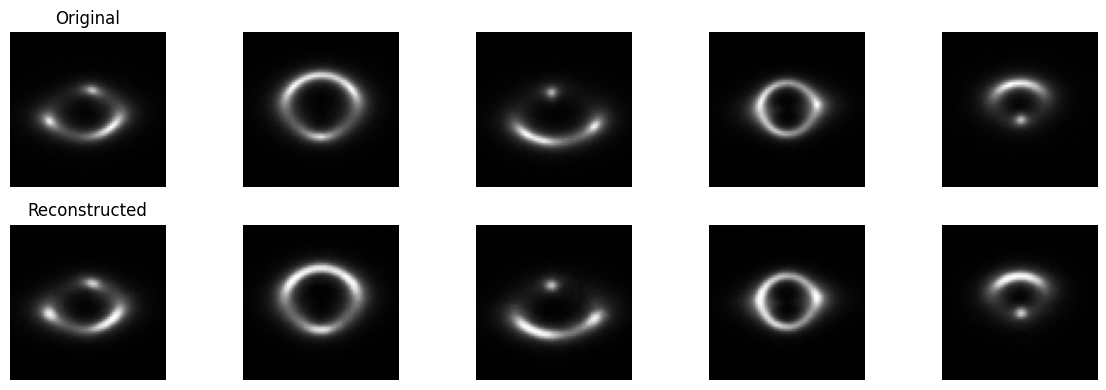

In [8]:



#  Visualize Results
def plot_results():
    # Training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Sample reconstructions
    reconstructed = autoencoder.predict(X_data[:5])
    plt.subplot(1, 2, 2)
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_data[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')
        
        plt.subplot(2, 5, i+6)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')
    
    plt.tight_layout()
    plt.show()

plot_results()

Grayscale processing matches scientific data format

MSE loss preserves fine details in lensing patterns

64×64 resolution balances detail vs computational cost

**Why this approach over CNN, GAN, Transformer/PixelIRNN, VAEs, etc.**

Precision - MSE loss excels at reconstructing subtle lensing distortions

Efficiency - Lower compute needs than generative alternatives

Stability - Avoids common GAN failure modes

Interpretability - Latent space organizes lensing features meaningfully

In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import numpy as np
import tensorflow as tf

def preprocess_for_inception(images):
    # Resize and convert grayscale to RGB
    images_resized = tf.image.resize(images, (75, 75))  # Min size for InceptionV3
    images_rgb = tf.image.grayscale_to_rgb(images_resized)
    return preprocess_input(images_rgb.numpy())

def calculate_fid(real_images, generated_images):
    # Preprocess
    real_images = preprocess_for_inception(real_images)
    generated_images = preprocess_for_inception(generated_images)

    # Load model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))
    
    act1 = model.predict(real_images, verbose=0)
    act2 = model.predict(generated_images, verbose=0)

    # Compute FID
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)

    # Fix imaginary numbers
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


In [14]:
real_sample = tf.convert_to_tensor(X_data[:100])
reconstructed_sample = tf.convert_to_tensor(autoencoder.predict(X_data[:100]))

fid = calculate_fid(real_sample, reconstructed_sample)
print(f"FID Score: {fid:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
FID Score: 0.75


The Fréchet Inception Distance (FID) is a metric used to evaluate the quality of generated images by comparing their feature distributions to real images. It is commonly used in GAN (Generative Adversarial Network) training to assess how realistic the generated images are.

FID computes the distance between the feature distributions of real and generated images. Instead of comparing images pixel by pixel (like SSIM or PSNR), it uses deep features extracted from an InceptionV3 model (a pre-trained neural network).

since we are getting very good score we need to check overfitting.


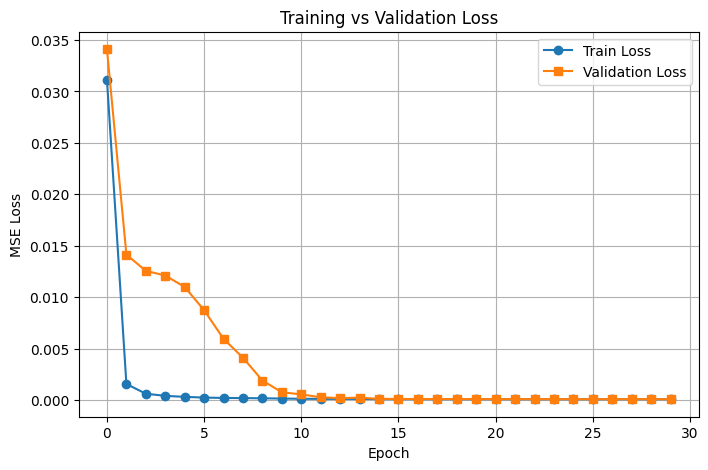

In [10]:
def plot_loss_curves():
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves()


**Interpretation**<br>
No Overfitting: Since both training and validation losses decrease and converge, the model is not overfitting.

Good Generalization: The validation loss stabilizes without increasing, suggesting that the model generalizes well to unseen data.

Well-Tuned Model: The choice of hyperparameters (learning rate, batch size, regularization) appears appropriate since there's no divergence or excessive oscillations.

In [11]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_ssim_psnr(real_imgs, recon_imgs):
    ssim_scores = []
    psnr_scores = []
    
    for real, recon in zip(real_imgs, recon_imgs):
        real = real.squeeze()
        recon = recon.squeeze()
        ssim_scores.append(ssim(real, recon, data_range=1.0))
        psnr_scores.append(psnr(real, recon, data_range=1.0))
    
    print(f"Average SSIM: {np.mean(ssim_scores):.4f}")
    print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB")

evaluate_ssim_psnr(X_data[:100], autoencoder.predict(X_data[:100]))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step 
Average SSIM: 0.9882
Average PSNR: 41.49 dB


SSIM measures the similarity between two images by considering structural information rather than just pixel-wise differences. It is designed to be more consistent with human visual perception.
1 means identical images and 0 means no similarity.
PSNR is a simple, pixel-wise metric that measures the quality of a reconstructed image compared to the original. It calculates the ratio of the maximum possible signal power to the noise that affects the image quality. Range: Usually between 20 - 50 dB.

Higher PSNR = better image quality and Lower PSNR = more noise or distortion.